# Generate the Training Points

In [17]:
from trainingpoints import pk_linear

In [18]:
NLHS = 500
cosmos, pkl = pk_linear(f'lhs_{NLHS}')

# Test Gaussian Process

In [1]:
import pandas as pd
import torch
import matplotlib.pylab as plt

# our script and functions
import utils.helpers as hp
from src.gp.gaussianprocess import GaussianProcess
import config as CONFIG
import src.cosmology as sc

# plotting tricks 
plt.rc("text", usetex=True)
plt.rc("font", **{"family": "sans-serif", "serif": ["Palatino"]})
fontSize = 20

In [2]:
NITER = 1000
LR = 0.01
NRES = 2
NLHS = 500

In [3]:
inputs = hp.load_csv('data', f'cosmologies_lhs_{NLHS}')
outputs = hp.load_csv('data', f'pk_linear_lhs_{NLHS}')

In [4]:
ins = torch.from_numpy(inputs.values)
out = torch.from_numpy(outputs.iloc[:,0].values)

In [5]:
test = GaussianProcess(ins, out, jitter = 1E-10)
opt = test.optimisation(torch.randn(ins.shape[1]+1), niter = NITER, lrate = LR, nrestart = NRES)

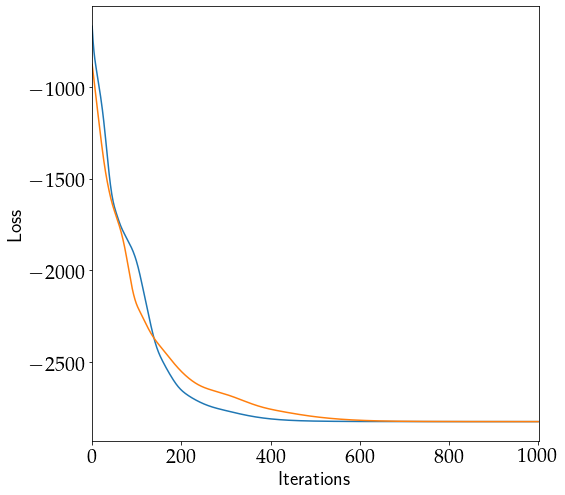

In [6]:
plt.figure(figsize = (8,8))
for i in range(len(opt)):  
    plt.plot(range(NITER + 1), opt[i]['loss'])
plt.xlim(0, NITER + 1)
plt.xlabel("Iterations", fontsize=fontSize)
plt.ylabel("Loss", fontsize=fontSize)
plt.tick_params(axis="x", labelsize=fontSize)
plt.tick_params(axis="y", labelsize=fontSize)
plt.show()

In [7]:
ins[0]

tensor([0.1497, 0.0330, 0.7362, 4.1013], dtype=torch.float64)

In [8]:
test.ystd

tensor(1.7986, dtype=torch.float64)

In [9]:
test.ymean

tensor(5.0889, dtype=torch.float64)

In [10]:
# parameter = {'Omega_cdm': 0.25, 'Omega_b': 0.04, 'h':0.70, 'z': 0.25}
point = torch.tensor([0.25, 0.04, 0.70, 0.25])

In [11]:
%%time
test.predict_mean(point)

CPU times: user 516 µs, sys: 179 µs, total: 695 µs
Wall time: 486 µs


tensor([1033.8930], dtype=torch.float64)

In [12]:
%%time
mean, var = test.predict_mean_var(point)

CPU times: user 10.2 ms, sys: 0 ns, total: 10.2 ms
Wall time: 2.07 ms


In [13]:
mean

tensor([1033.8930], dtype=torch.float64)

In [14]:
torch.sqrt(var)

tensor([0.0934], dtype=torch.float64)

In [15]:
print(mean - 3*torch.sqrt(var), mean + 3*torch.sqrt(var))

tensor([1033.6128], dtype=torch.float64) tensor([1034.1731], dtype=torch.float64)


In [16]:
%%time
test.gradient(point)

CPU times: user 4.04 ms, sys: 1.4 ms, total: 5.44 ms
Wall time: 809 µs


tensor([-11064.6777,   2470.4670,  -9312.0869,  -1056.2693])

In [17]:
%%time
test.hessian(point)

CPU times: user 2.28 ms, sys: 11.4 ms, total: 13.7 ms
Wall time: 2.72 ms


tensor([[166806.1562, -24187.3164, 100583.7344,   9705.2617],
        [-24187.3184, -10663.9531, -14599.6768,  -4285.7383],
        [100583.7344, -14599.6768,  97873.6641,   9440.9512],
        [  9705.2617,  -4285.7383,   9440.9512,   1137.2081]])

In [18]:
module = sc.PowerSpectrum(CONFIG.Z_MIN, CONFIG.Z_MAX, CONFIG.K_MIN, CONFIG.K_MAX)
parameter = {'sigma8': CONFIG.FIX_SIGMA8, 'Omega_cdm': 0.25, 'Omega_b': 0.04, 'h': 0.70, 'n_s': CONFIG.FIX_NS}
plin = module.pk_linear(cosmology=parameter, redshift = 0.25)

In [19]:
plin[0]

1034.0753471121718

In [ ]:
EPS = 1E-3
parameter_p = {'sigma8': CONFIG.FIX_SIGMA8, 'Omega_cdm': 0.25+EPS, 'Omega_b': 0.04, 
               'h': 0.70, 'n_s': CONFIG.FIX_NS}
parameter_m = {'sigma8': CONFIG.FIX_SIGMA8, 'Omega_cdm': 0.25-EPS, 'Omega_b': 0.04, 
               'h': 0.70, 'n_s': CONFIG.FIX_NS}
plin_p = module.pk_linear(cosmology=parameter_p, redshift = 0.25)
plin_m = module.pk_linear(cosmology=parameter_m, redshift = 0.25)

In [21]:
class_grad = (plin_p - plin_m) / (2 * EPS)

In [22]:
class_grad[0]

-11071.8337939731

# Testing

Here I am testing the equation David shared:

$$
P(k,z,\sigma_{8},n_{s}, \theta) = \left(\dfrac{\sigma_{8}}{\sigma_{8*}}\right)^{2}\,\left(\dfrac{k}{k_{\textrm{pivot}}}\right)^{n_{s}-n_{s*}}\,P(k,z,\sigma_{8*},n_{s*}, \theta)
$$

In [1]:
import matplotlib.pylab as plt 

import src.cosmology as sc
import config as CONFIG

# plotting tricks 
plt.rc("text", usetex=True)
plt.rc("font", **{"family": "sans-serif", "serif": ["Palatino"]})
fontSize = 20

In [2]:
module = sc.PowerSpectrum(CONFIG.Z_MIN, CONFIG.Z_MAX, CONFIG.K_MIN, CONFIG.K_MAX)
parameter = {'sigma8': 0.857570, 'Omega_cdm': 0.217284, 'Omega_b': 0.038872, 'h': 0.711447, 'n_s': 1.001982}
plin = module.pk_linear(cosmology=parameter)

In [3]:
parameter2 = {'sigma8': 0.8, 'Omega_cdm': 0.217284, 'Omega_b': 0.038872, 'h': 0.711447, 'n_s': 1.00}
plin2 = module.pk_linear(cosmology=parameter2)

In [7]:
testing = (parameter['sigma8']/parameter2['sigma8'])**2 * (module.wavenumber/0.05)**(parameter['n_s'] - parameter2['n_s']) * plin2

In [11]:
plin/testing

array([0.99842953, 0.99842953, 0.99842953, 0.99842953, 0.99842953,
       0.99842953, 0.99842953, 0.99842953, 0.99842953, 0.99842953,
       0.99842953, 0.99842953, 0.99842953, 0.99842953, 0.99842953,
       0.99842953, 0.99842953, 0.99842953, 0.99842953, 0.99842953,
       0.99842953, 0.99842953, 0.99842953, 0.99842953, 0.99842953,
       0.99842953, 0.99842953, 0.99842953, 0.99842953, 0.99842953,
       0.99842953, 0.99842953, 0.99842953, 0.99842953, 0.99842953,
       0.99842953, 0.99842953, 0.99842953, 0.99842953, 0.99842953])

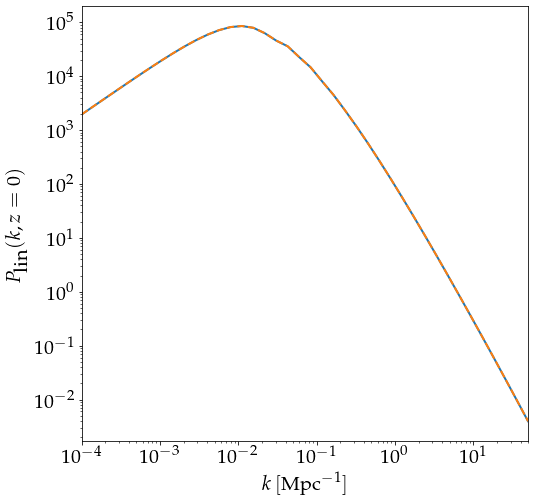

In [10]:
plt.figure(figsize = (8,8))
plt.loglog(module.wavenumber, plin, lw = 2)
plt.loglog(module.wavenumber, testing, lw = 2, linestyle = '--')
plt.xlim(module.k_min, module.k_max)
plt.ylabel(r'$P_{\textrm{lin}}(k,z=0)$', fontsize = fontSize)
plt.xlabel(r'$k\,[\textrm{Mpc}^{-1}]$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

# Train GPs

In [1]:
from src.gp.training import train_gps
import config as CONFIG

In [2]:
CONFIG.LEARN_RATE = 1e-2
CONFIG.NRESTART = 2
CONFIG.NITER = 1000

In [3]:
%%time
gps = train_gps(500, jitter = 1E-10)

Training GP 1
Training GP 2
Training GP 3
Training GP 4
Training GP 5
Training GP 6
Training GP 7
Training GP 8
Training GP 9
Training GP 10
Training GP 11
Training GP 12
Training GP 13
Training GP 14
Training GP 15
Training GP 16
Training GP 17
Training GP 18
Training GP 19
Training GP 20
Training GP 21
Training GP 22
Training GP 23
Training GP 24
Training GP 25
Training GP 26
Training GP 27
Training GP 28
Training GP 29
Training GP 30
Training GP 31
Training GP 32
Training GP 33
Training GP 34
Training GP 35
Training GP 36
Training GP 37
Training GP 38
Training GP 39
Training GP 40
CPU times: user 1h 10min 8s, sys: 16.9 s, total: 1h 10min 25s
Wall time: 9min 47s


# Load GPs and Make Predictions

In [11]:
import torch
import utils.helpers as hp 
import config as CONFIG

NLHS = 500
# parameter = {'Omega_cdm': 0.25, 'Omega_b': 0.04, 'h':0.70, 'z': 0.25}
param = [0.25, 0.04, 0.70, 0.25]

In [8]:
gps = list()

for i in range(CONFIG.NWAVE):
    gp = hp.load_list(f"gps/{NLHS}", f"pk_linear_lhs_{NLHS}_wave_{i}")
    gps.append(gp)

In [13]:
preds = list()

for i in range(CONFIG.NWAVE):
    pred = gps[i].predict_mean(torch.tensor(param)).data[0].item()
    preds.append(pred)

### Compare with CLASS

In [14]:
import matplotlib.pylab as plt
import src.cosmology as sc

# plotting tricks 
plt.rc("text", usetex=True)
plt.rc("font", **{"family": "sans-serif", "serif": ["Palatino"]})
fontSize = 20

In [15]:
module = sc.PowerSpectrum(CONFIG.Z_MIN, CONFIG.Z_MAX, CONFIG.K_MIN, CONFIG.K_MAX)
parameter = {'Omega_cdm': param[0], 'Omega_b': param[1], 
             'sigma8': CONFIG.FIX_SIGMA8, 'n_s': CONFIG.FIX_NS, 'h':param[2]}
plin = module.pk_linear(cosmology=parameter, redshift = param[3])

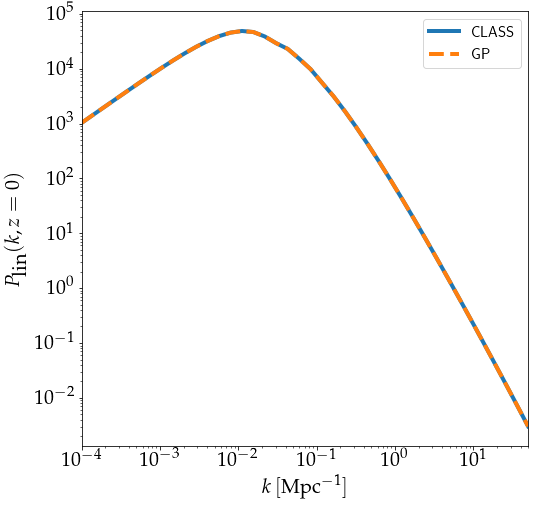

In [16]:
plt.figure(figsize = (8,8))
plt.loglog(module.wavenumber, plin, lw = 4, label = 'CLASS')
plt.loglog(module.wavenumber, preds, lw = 4, label = 'GP', linestyle = '--')
plt.xlim(module.k_min, module.k_max)
plt.ylabel(r'$P_{\textrm{lin}}(k,z=0)$', fontsize = fontSize)
plt.xlabel(r'$k\,[\textrm{Mpc}^{-1}]$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

# Points from the Prior

In [17]:
import torch
import numpy as np
import matplotlib.pylab as plt

# our scripts and functions
import utils.helpers as hp 
import src.cosmology as sc
from trainingpoints import generate_prior
import config as CONFIG

# plotting tricks 
plt.rc("text", usetex=True)
plt.rc("font", **{"family": "sans-serif", "serif": ["Palatino"]})
fontSize = 20

Load all the GPs

In [18]:
NLHS = 500
gps = list()

for i in range(CONFIG.NWAVE):
    gp = hp.load_list(f"gps/{NLHS}", f"pk_linear_lhs_{NLHS}_wave_{i}")
    gps.append(gp)

Generate class for computing the linear matter power spectrum with CLASS.

In [19]:
module = sc.PowerSpectrum(CONFIG.Z_MIN, CONFIG.Z_MAX, CONFIG.K_MIN, CONFIG.K_MAX)

Generate the prior distributions

In [20]:
# create an empty list to store the distributions
priors = {}

for param in CONFIG.COSMO:
    priors[param] = generate_prior(CONFIG.PRIORS[param])

Function to generate points from the prior.

In [21]:
def generate_points(priors: dict, number: int = 100) -> list:
    points = list()
    
    for i in range(number):
        point = {}
        
        for param in CONFIG.COSMO:
            point[param] = priors[param].rvs()
            
        points.append(point)
        
    return points

Function to make predictions using the emulator, given the list of GPs and the inputs (points).

In [22]:
def emulator_predictions(gps: list, points: list) -> list:
    
    npoints = len(points)
    predictions = list()
    
    for p in range(npoints):
        preds = list()
        param = list(points[p].values())
        for i in range(CONFIG.NWAVE):
            pred = gps[i].predict_mean(torch.tensor(param)).data[0].item()
            preds.append(pred)
        predictions.append(preds)
    return predictions

Function to make predictions using the simulator (CLASS) given the inputs (points).

In [33]:
def simulator_predictions(points: list) -> list:
    npoints = len(points)
    predictions = list()
    for p in range(npoints):
        parameter = {'Omega_cdm': points[p]['Omega_cdm'], 'Omega_b': points[p]['Omega_b'], 
             'sigma8': CONFIG.FIX_SIGMA8, 'n_s': CONFIG.FIX_NS, 'h':points[p]['h']}
        plin = module.pk_linear(cosmology = parameter, redshift = points[p]['z'])
        predictions.append(plin)
    return predictions

### Quick Test

In [24]:
points = generate_points(priors, 3)

In [25]:
%%time
emu_preds = emulator_predictions(gps, points)

CPU times: user 48.2 ms, sys: 3.99 ms, total: 52.2 ms
Wall time: 50.3 ms


In [34]:
%%time
sim_preds = simulator_predictions(points)

CPU times: user 1min 27s, sys: 83.6 ms, total: 1min 27s
Wall time: 13.7 s


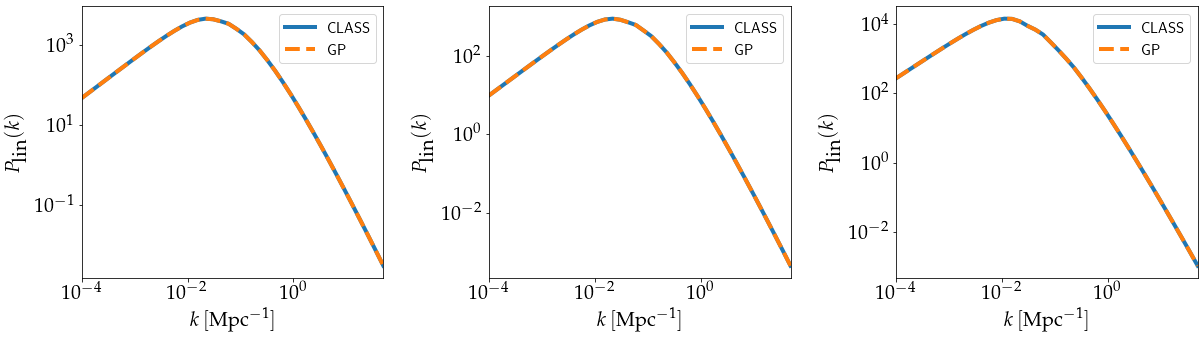

In [53]:
plt.figure(figsize = (20, 5))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.loglog(module.wavenumber, sim_preds[i], lw = 4, label = 'CLASS')
    plt.loglog(module.wavenumber, emu_preds[i], lw = 4, label = 'GP', linestyle = '--')
    plt.xlim(module.k_min, module.k_max)
    plt.ylabel(r'$P_{\textrm{lin}}(k)$', fontsize = fontSize)
    plt.xlabel(r'$k\,[\textrm{Mpc}^{-1}]$', fontsize = fontSize)
    plt.tick_params(axis='x', labelsize=fontSize)
    plt.tick_params(axis='y', labelsize=fontSize)
    plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.subplots_adjust(wspace = 0.35)
plt.show()

### Generate Many Points and Compute Residuals

In [55]:
NTEST = 200

In [36]:
points = generate_points(priors, NTEST)

In [37]:
%%time
emu_preds = emulator_predictions(gps, points)

CPU times: user 1.57 s, sys: 3.99 ms, total: 1.58 s
Wall time: 1.58 s


In [38]:
%%time
sim_preds = simulator_predictions(points)

CPU times: user 1h 44min 59s, sys: 7.02 s, total: 1h 45min 6s
Wall time: 15min 58s


In [40]:
emu_preds = np.asarray(emu_preds) 
sim_preds = np.asarray(sim_preds)

### Interpolation

So we obtain smooth power spectrum, as a function of the wavenumber, $k$.

In [41]:
import scipy.interpolate as itp

def interpolate(inputs: list) -> np.ndarray:
    '''
    Function to interpolate the power spectrum along the redshift axis
    :param: inputs (list or tuple) : x values, y values and new values of x
    :return: ynew (np.ndarray) : an array of the interpolated power spectra
    '''

    x, y, xnew = np.log(inputs[0]), np.log(inputs[1]), np.log(inputs[2])
    spline = itp.splrep(x, y)
    ynew = itp.splev(xnew, spline)
    return np.exp(ynew)

In [42]:
wavenumbers = module.wavenumber
wavenumbers_new = np.geomspace(CONFIG.K_MIN, CONFIG.K_MAX, 1000)

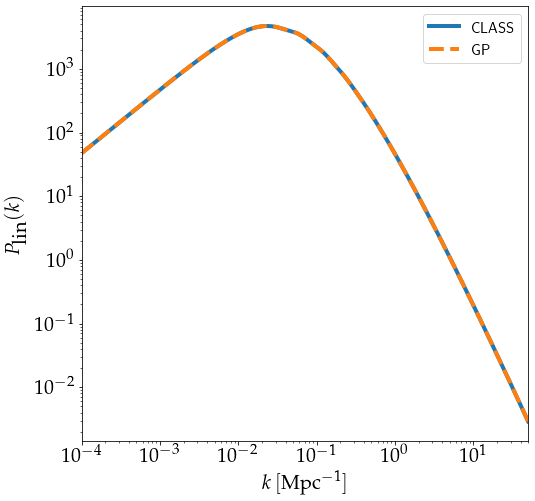

In [44]:
plt.figure(figsize = (8,8))
plt.loglog(wavenumbers_new, interpolate([wavenumbers, emu_preds[0], wavenumbers_new]), lw = 4, label = 'CLASS')
plt.loglog(wavenumbers_new, interpolate([wavenumbers, sim_preds[0], wavenumbers_new]), lw = 4, label = 'GP', linestyle = '--')
plt.xlim(module.k_min, module.k_max)
plt.ylabel(r'$P_{\textrm{lin}}(k)$', fontsize = fontSize)
plt.xlabel(r'$k\,[\textrm{Mpc}^{-1}]$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

In [56]:
emu_preds_int = np.asarray([interpolate([wavenumbers, emu_preds[i], wavenumbers_new]) for i in range(NTEST)])
sim_preds_int = np.asarray([interpolate([wavenumbers, sim_preds[i], wavenumbers_new]) for i in range(NTEST)])

In [57]:
diff = emu_preds_int - sim_preds_int
frac = diff/sim_preds_int

In [58]:
print(f'Maximum percentage error: {np.amax(np.abs(frac)) * 100:.2f}')

Maximum percentage error: 3.86


In [59]:
frac_mean = np.mean(frac, axis = 0)
frac_std = np.std(frac, axis = 0)

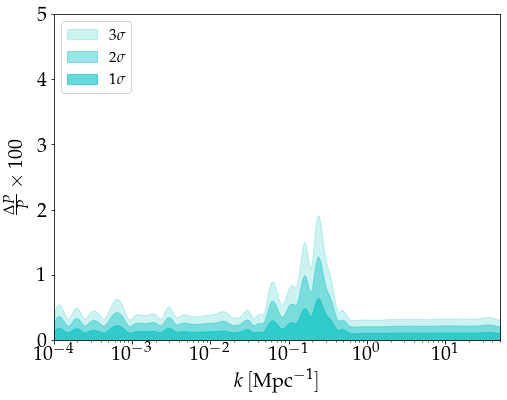

In [77]:
plt.figure(figsize = (8,6))
plt.fill_between(wavenumbers_new, 100*(frac_mean + 3 * frac_std), 0, color = 'c', alpha = 0.2, label = r'$3\sigma$')
plt.fill_between(wavenumbers_new, 100*(frac_mean + 2 * frac_std), 0, color = 'c', alpha = 0.4, label = r'$2\sigma$')
plt.fill_between(wavenumbers_new, 100*(frac_mean + 1 * frac_std), 0, color = 'c', alpha = 0.6, label = r'$1\sigma$')
plt.xlim(min(module.wavenumber), max(module.wavenumber))
plt.ylim(0.0, 5.0)
plt.xscale('log')
plt.ylabel(r'$\frac{\Delta P}{P} \times 100$', fontsize = fontSize)
plt.xlabel(r'$k\,[\textrm{Mpc}^{-1}]$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})
plt.show()

# General Linear Matter Power Spectrum

Here, we use the first equation to get linear matter power spectrum for any $\sigma_{8}$ and $n_{s}$.

To be merged with CCL.

In [88]:
import scipy

In [89]:
def generate_prior(dictionary: dict) -> dict:
    """Generates the entity of each parameter by using scipy.stats function.

    Args:
        dictionary (dict): A dictionary with the specifications of the prior.

    Returns:
        dict: the prior distribution of the parameter.
    """
    dist = getattr(scipy.stats, dictionary["distribution"])(*dictionary["specs"])
    return dist

def generate_cosmo_prior(config) -> dict:
    
    priors = {}

    for param in CONFIG.COSMO:
        priors[param] = generate_prior(CONFIG.PRIORS[param])

    return priors

In [310]:
class emuPredict(object):
    def __init__(self, config, gps):
        self.priors = generate_cosmo_prior(config.PRIORS)
        self.gps = gps 
        self.config = config
        self.wavenumber = torch.logspace(np.log10(config.K_MIN), np.log10(config.K_MAX), config.NWAVE)
        
    def check_prior(self, parameter: dict):
        logprior = 0.0
        for p in parameter:
            logprior += self.priors[p].logpdf(parameter[p]) 
        if not np.isfinite(logprior):
            print('Parameter is outside prior box.')
            
    def calculate_prefactor(self, parameter):
        """
        parameter[0]: sigma8
        parameter[1]: n_s
        """
        pre_sigma8 = (parameter[0]/self.config.FIX_SIGMA8)**2
        pre_ns = (self.wavenumber / self.config.FIX_K_PIVOT)**(parameter[1] - self.config.FIX_NS)
        prefactor = pre_sigma8 * pre_ns
        return prefactor
    
    def calculate_der_sigma8(self, cosmology, pklin_fix):
        pre_sigma8 = (cosmology['sigma8']/self.config.FIX_SIGMA8)**2
        
        # the factor 1.0 arises due to the derivative calculation
        pre_ns = (self.wavenumber / self.config.FIX_K_PIVOT)**(1.0 + cosmology['n_s'] - self.config.FIX_NS)
        
        grad_sigma8 = 2.0 * pre_sigma8 * pre_ns * pklin_fix
        grad_ns = -self.config.FIX_NS * pre_sigma8 * pre_ns * pklin_fix 
        return grad_sigma8, grad_ns
        
    def calculate_gp_mean(self, redshift: float, parameter: dict):
        self.check_prior(parameter)
        param = torch.tensor([parameter['Omega_cdm'], parameter['Omega_b'], parameter['h'], redshift])
        pred = torch.tensor([gps[i].predict_mean(param).data[0].item() for i in range(self.config.NWAVE)])
        return pred
    
    def calculate_gp_gradient(self, redshift: float, parameter: dict):
        self.check_prior(parameter)
        param = torch.tensor([parameter['Omega_cdm'], parameter['Omega_b'], parameter['h'], redshift])
        gradients = torch.vstack([self.gps[i].gradient(param) for i in range(self.config.NWAVE)]).numpy()
        return gradients
    
    def calculate_gp_hessian(self, redshift: float, parameter: dict):
        self.check_prior(parameter)
        param = torch.tensor([parameter['Omega_cdm'], parameter['Omega_b'], parameter['h'], redshift])
        hessian = torch.stack([self.gps[i].hessian(param) for i in range(self.config.NWAVE)]).numpy()
        return hessian
    
    def calculate_mean_pklin(self, redshift: float, cosmo: dict):
        
        gp_cosmo = {'Omega_cdm': cosmology['Omega_cdm'],
                'Omega_b': cosmology['Omega_b'],
                'h': cosmology['h']}
        
        # extra parameters
        pre_param = torch.tensor([cosmo['sigma8'], cosmo['n_s']])
        
        gp_mean = self.calculate_gp_mean(redshift, gp_cosmo)
        prefactor = self.calculate_prefactor(pre_param)
        pred_pklin = prefactor * gp_mean
        return pred_pklin.numpy()
    
    def calculate_gradient_pklin(self, redshift, cosmo: dict):
        gp_cosmo = {'Omega_cdm': cosmology['Omega_cdm'],
                'Omega_b': cosmology['Omega_b'],
                'h': cosmology['h']}
        
        gp_gradient = self.calculate_gp_gradient(redshift, gp_cosmo)
        gp_mean = self.calculate_gp_mean(redshift, gp_cosmo)
        
        # calculate the term containing sigma8 and n_s
        pre_param = torch.tensor([cosmo['sigma8'], cosmo['n_s']])
        prefactor = self.calculate_prefactor(pre_param).view(-1, 1)
        
        # the derivatives of sigma8 and n_s are hardcoded 
        grad_sigma8, grad_ns = self.calculate_der_sigma8(cosmo, gp_mean)
        
        # the derivatives of the other parameters
        grads = prefactor * gp_gradient
        
        # dictionary to output all derivatives 
        gradients = {}
        gradients['sigma8'] = grad_sigma8.numpy()
        gradients['n_s'] = grad_ns.numpy()
        gradients['Omega_cdm'] = grads[:,0].numpy()
        gradients['Omega_b'] = grads[:,1].numpy()
        gradients['h'] = grads[:,2].numpy()
        gradients['z'] = grads[:,3].numpy()
        return gradients

In [311]:
testing = emuPredict(CONFIG, gps)

In [312]:
cosmogp = {'Omega_cdm': 0.25, 'Omega_b': 0.04, 'h': 0.70}
cosmology = {'Omega_cdm': 0.25, 'Omega_b': 0.04, 'h': 0.70, 'n_s': 1.0, 'sigma8': 0.75}

In [314]:
gp_mean = testing.calculate_gp_mean(0.0, cosmogp)
gp_gradient = testing.calculate_gp_gradient(0.0, cosmogp)
gp_hessian = testing.calculate_gp_hessian(0.0, cosmogp)

In [323]:
pklin = testing.calculate_mean_pklin(0.0, cosmology)
gradients = testing.calculate_gradient_pklin(0.0, cosmology)

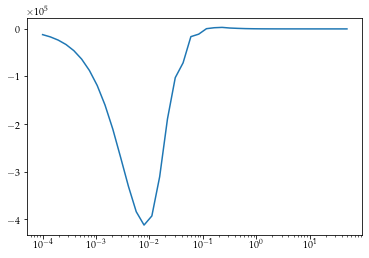

In [324]:
plt.figure()
plt.plot(testing.wavenumber, gradients['Omega_cdm'])
plt.xscale('log')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
plt.show()